In [55]:
# importing libraries
import pandas as pd
import numpy as np
from pandas_profiling import ProfileReport
from scipy.stats import chi2_contingency, ttest_ind
import missingno as mno
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics, svm 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

import time 
import numpy as np

from sklearn.inspection import permutation_importance

from sklearn.metrics import average_precision_score, precision_recall_curve, \
    plot_precision_recall_curve
%matplotlib inline

# Loading Data

In [2]:
# loading data
file_to_load = "../Resources/data.csv"

no_touch_data = pd.read_csv(file_to_load)
titanic_data = no_touch_data
titanic_data.head(2)

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   

   Parch     Ticket     Fare Cabin Embarked  
0      0  A/5 21171   7.2500   NaN        S  
1      0   PC 17599  71.2833   C85        C

# Profiling with pandas profile

In [3]:
profile = ProfileReport(titanic_data, title='Titanic Profile Report', html= {'style':{'full_width':True}})

profile

Summarize dataset:   0%|          | 0/25 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [9]:
"""
PassengerID: This is just a Unique ID given to every passenger.
Survived: Which is a boolean, 0 meaning death,1 meaning that they lived. 
Pclass: What class did the passenger sit in? 1,2 or 3.
Sibsp: refers to the number of siblings or spouses aboard..
Parch: means the number of parents or children aboard.
Embarked: the points from where the ship embarked from 
Ticket is ticket number, Age, Sex, Name are a given, and Cabin is the cabin number.
"""

'\nPassengerID: This is just a Unique ID given to every passenger.\nSurvived: Which is a boolean, 0 meaning death,1 meaning that they lived. \nPclass: What class did the passenger sit in? 1,2 or 3.\nSibsp: refers to the number of siblings or spouses aboard..\nParch: means the number of parents or children aboard.\nEmbarked: the points from where the ship embarked from \nTicket is ticket number, Age, Sex, Name are a given, and Cabin is the cabin number.\n'

# Cleaning Data

<AxesSubplot:>

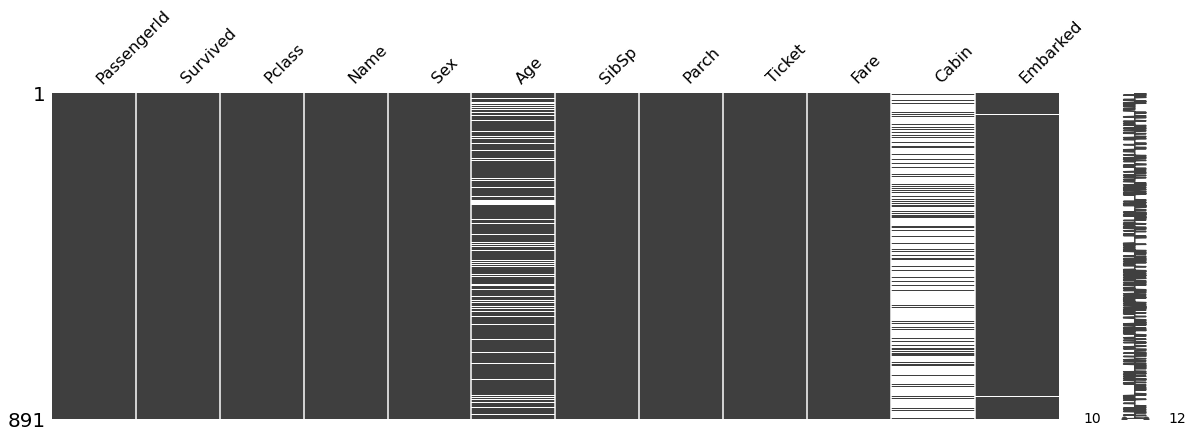

In [6]:
# checking which column has missing values 
mno.matrix(titanic_data, figsize = (20,6))

In [20]:
# setting missing columns up for simple random imputation
missing_columns= titanic_data[["Age","Cabin","Embarked"]]

# filling NAs with new features of mean and median
mean = missing_columns.Age.mean()
median = missing_columns.Age.median()

titanic_data["Age_imp_median"] = missing_columns.Age.fillna(median)
titanic_data["Age_imp_mean"] = missing_columns.Age.fillna(mean)

missing_columns.Age.fillna(mean).head(2)

0    22.0
1    38.0
Name: Age, dtype: float64

In [21]:
# Cleaning names - adding title feature
titanic_data['Name_title'] = titanic_data.Name.apply(lambda x: x.split(',')[1].split('.')[0].strip())

In [22]:
# cleaning cabin - moving to decks
titanic_data['Cabin_decks'] = titanic_data['Cabin'].str.replace('\d+','')

In [42]:
# making sex binary 
titanic_data['Sex_binary'] = [0 if x == 'male' else 1 for x in titanic_data['Sex']]

In [43]:
# seeing finished results 
titanic_data.head()

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked Name_title Cabin_decks  \
0      0         A/5 21171   7.2500   NaN        S         Mr         NaN   
1      0          PC 17599  71.2833   C85        C        Mrs           C   
2      0  STON/O2. 3101282   7.9250   NaN        S       Miss         NaN   
3      0            113803  53.1000  C123        S        Mrs           C   
4      0            373450   8.0500   NaN        S         Mr         NaN   

   Age_imp_median  Age_imp_mean  Sex_binary  
0            22.0          22.0           0  
1            38.0          38.0           1  
2            26.0          26.0           1  
3            35.0          35.0           1  
4            35.0          35.0           0

<AxesSubplot:>

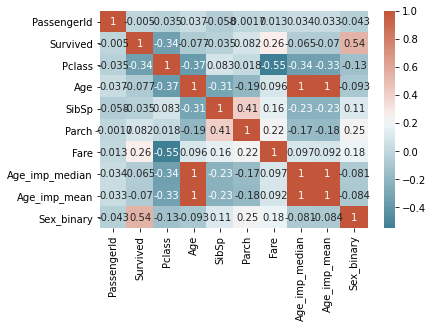

In [44]:
# initial correlation matrix
corr = titanic_data.corr()
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=True,
           cmap=sns.diverging_palette(220,20, as_cmap=True))

# Testing

In [25]:
# T-test
cat1 = titanic_data['Fare']
cat2 = titanic_data['Survived']

ttest_ind(cat1, cat2)

Ttest_indResult(statistic=19.112798902198033, pvalue=3.2324176960886792e-74)

# Regressions

Logistic Regression using Statsmodels

In [45]:
# defining the dependent and independent variables 
Xtrain = titanic_data[['SibSp','Parch','Fare','Age_imp_median','Sex_binary']]
ytrain = titanic_data['Survived']

# building the model and fitting the data
log_reg = sm.Logit(ytrain,Xtrain).fit()

Optimization terminated successfully.
         Current function value: 0.489084
         Iterations 6


In [46]:
# confusion matrix
log_reg.pred_table(threshold=.7)

array([[507.,  42.],
       [163., 179.]])

# Logistic regression using scikitlearn

[[116  18]
 [ 27  62]]


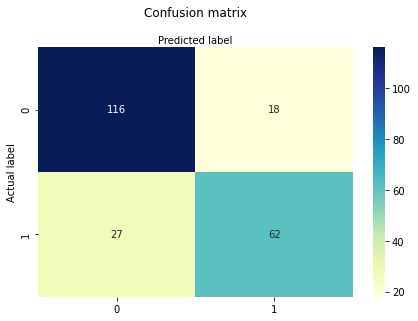

Accuracy: 0.7982062780269058
Precision: 0.775
Recall: 0.6966292134831461


In [47]:
# Creating X and y
X = titanic_data[['SibSp','Parch','Fare','Age_imp_median','Sex_binary']]
y = titanic_data.Survived

# use train_test_splie to create training and testing data 
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# instantiate model
logreg = LogisticRegression()
# fit the model with data 
logreg.fit(X_train, y_train)
# preform prediction on test set
y_pred = logreg.predict(X_test)

# creating metrics
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
print(cnf_matrix)

# making acual confusion matrix tiles
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

# getting accuracy, precision, recall
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))

# Feature importance

In [48]:
# X = titanic_data[['SibSp','Parch','Fare','Age_imp_median','Sex_binary']]
# y = titanic_data.Survived

In [49]:
feature_names = [f'feature {i}' for i in range(Xtrain.shape[1])]
forest = RandomForestClassifier(random_state=0)
forest.fit(Xtrain, ytrain)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

Feature importance on mean decrease in impurity

In [50]:
start_time = time.time()
importances = forest.feature_importances_
std = np.std([
    tree.feature_importances_ for tree in forest.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: "
      f"{elapsed_time:.3f} seconds")

Elapsed time to compute the importances: 0.009 seconds


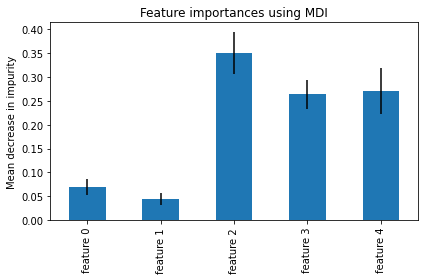

In [51]:
forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

# Precision Curve

In [53]:
# creating X and y
X = titanic_data[['SibSp','Parch','Fare','Age_imp_median','Sex_binary']]
y = titanic_data["Survived"].values.reshape(-1,1)
print(X.shape, y.shape)

# spliting data into training and testing 
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Create a simple classifier
classifier = svm.LinearSVC(random_state=np.random.RandomState(0))
classifier.fit(X_train, y_train)
y_score = classifier.decision_function(X_test)

(891, 5) (891, 1)


/Users/davispage/opt/anaconda3/envs/PythonData/lib/python3.6/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/davispage/opt/anaconda3/envs/PythonData/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [56]:
# computing the average precision score
average_precision = average_precision_score(y_test, y_score)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

Average precision-recall score: 0.76


Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.76')

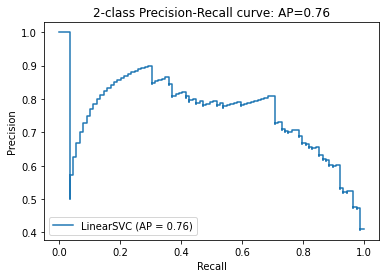

In [57]:
# plotting the precision-recall curve 
disp = plot_precision_recall_curve(classifier, X_test, y_test)
disp.ax_.set_title('2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(average_precision))

# Changing threshold

In [58]:
# definig the dependent and idenpendent variables
X = titanic_data[['SibSp','Parch','Fare','Age_imp_median','Sex_binary']]
y = titanic_data["Survived"].values.reshape(-1,1)

# building the model and fitting the data
log_reg = sm.Logit(ytrain,Xtrain).fit()

Optimization terminated successfully.
         Current function value: 0.489084
         Iterations 6


0.1


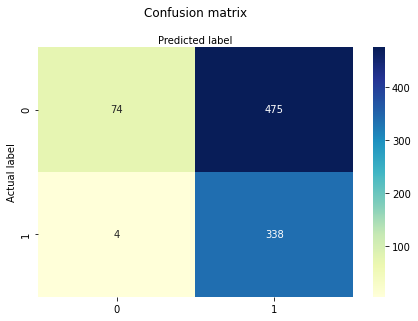

0.2


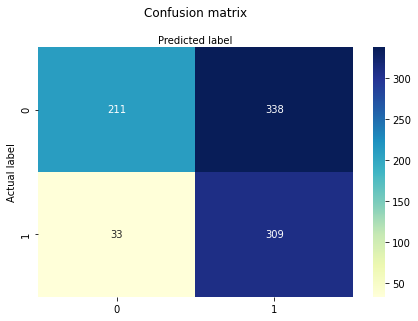

0.3


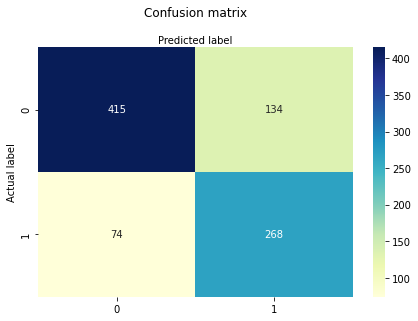

0.4


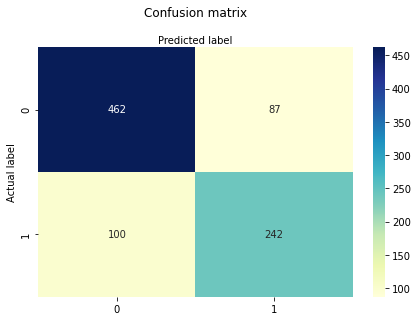

0.5


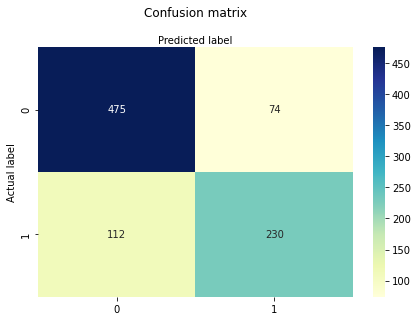

0.6


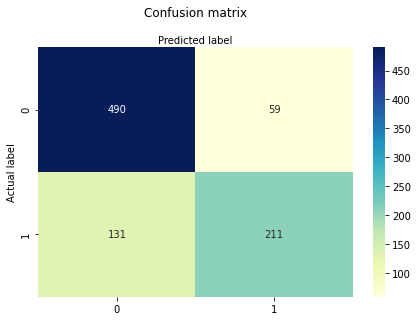

0.7


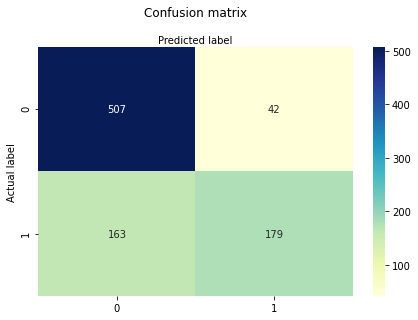

0.8


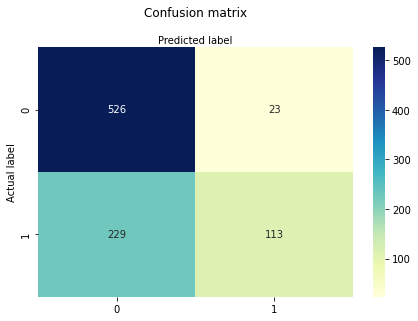

0.9


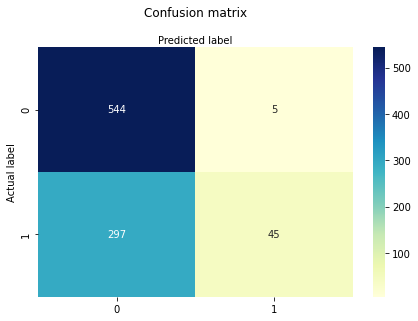

In [59]:
for threshold in range(1,10):
    threshold = round(threshold * .1,1)
    print(threshold)
    # print(log_reg.pred_table(threshold))
    log_reg.pred_table(threshold)
    class_names=[0,1] # name  of classes
    fig, ax = plt.subplots()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)
    # create heatmap
    sns.heatmap(pd.DataFrame(log_reg.pred_table(threshold)), annot=True, cmap="YlGnBu" ,fmt='g')
    ax.xaxis.set_label_position("top")
    plt.tight_layout()
    plt.title('Confusion matrix', y=1.1)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.show()